# Do Federal MPs who look the same, vote the same?

This workbook trains a Siamese Neural Network to learn the similarities and differences between Australian Federal MPs, based on their voting agreement rates (sourced from TheyVoteForYou.org.au).

The code for this workbook was taken (and modified extensively) from https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb

In [5]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import requests
import pandas as pd
from pandas.io.json import json_normalize
import wget
from bs4 import BeautifulSoup
from skimage import io, transform

## Helper Functions

In [6]:
def imshow(img,text = "",should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration

In [23]:
class Config():
    photos = "/home/ubuntu/pollies/"
    fetch_photos = False # Make this true to collect the photos from the web, rather than the local store.
    vote_distances = "/home/ubuntu/pollies/vote_distances.npy"
    fetch_distances = False # Make this true to scrape the distances from the web, rather than the local file
    train_batch_size = 64
    train_number_epochs = 10

## Collecting photos and agreement rates

This collects all the information required to generate training data, which will consist of
0. a politician's photo
1. another politicians photo
2. their "friendship" score, from TheyVoteForYou.org.au

To start with, we need to get a list of all of the politicians, and download their images. Some of this has to be done manually due to gaps in the data.

In [9]:
r = requests.get('https://theyvoteforyou.org.au/api/v1/people.json?key=fs4ZFvP5UjllPB7eIeyg')
j = r.json()

pollies = json_normalize(j)
reps = pollies[pollies['latest_member.house'] == 'representatives']

if Config.fetch_photos :
    for lab, row in reps.iterrows() :
        # We want to collect all the politician photos and save them locally
        url = 'https://www.openaustralia.org.au/images/mpsL/' + str(row['id']) + '.jpg'
        
        try :
            wget.download(url, out=Config.photos + "images/")
        except :
            print("Please download photo for " + 
                  row['latest_member.name.first'] + " " + 
                  row['latest_member.name.last'] + " manually, and save the file as " + 
                  Config.photos + "images/" + str(row['id']) + ".jpg")

Need to keep a few pollies aside for testing - let's keep 10 aside. Also need to clean up the data frame while we're at it.

In [10]:
df = (reps
      .rename(columns = {
          'latest_member.electorate' : 'electorate',
          'latest_member.name.first' : 'first_name',
          'latest_member.name.last' : 'last_name',
          'latest_member.party' : 'party' })
      .drop('latest_member.house', axis = 1)
      .drop('latest_member.id', axis = 1))
df['testing'] = False
df.iloc[random.sample(range(0, 150), 10),5] = True

We've now got photos for all of the pollies, and a few of them held out for testing, but we need some similarity scores to use as labels. We can get this from the TheyVoteForYou.org.au "friendship scores", AKA agreement rates. Unfortunately they aren't available through the API, so we'll have to scrape them.

In [11]:
if Config.fetch_distances :
    vote_dist = np.empty( (150,150) )
    
    for i in range(0,150) :
        pol_seat = df.iloc[i,1].lower()
        pol_name = (df.iloc[i,2] + "_" + df.iloc[i,3]).lower()
        print("Finding friends of " + df.iloc[i,2] + " " + df.iloc[i,3]) # Progress indication
        url = 'https://theyvoteforyou.org.au/people/representatives/' + pol_seat + "/" + pol_name + "/friends"
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        
        data = []
        table = soup.find('table', attrs={'class':'table'})
        table_body = table.find('tbody')
        rows = table_body.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            data.append([ele for ele in cols if ele]) # Get rid of empty values
        friends = pd.DataFrame(data, columns=['friendship', 'name', 'seat', 'party'])
        
        for j in range(0,150) :
            if i == j :
                vote_dist[i,j] = 0
            else :
                try :
                    # Need to be careful about matching seats here, because seats and members have moved 
                    # over time, so there are some dupes
                    friend_name = df.first_name.iloc[j] + " " + df.last_name.iloc[j]
                    friend_seat = df.electorate.iloc[j]
                    tmp = friends.loc[(friends.name == friend_name)]
                    score = tmp.loc[tmp.seat == friend_seat]['friendship'].values[0]
                    score = float(score.strip('%')) / 100
                    difference = 1 - score
                    vote_dist[i,j] = difference
                    # print(friend_name + " - ", difference) # Debug
                except :
                    print("Could not find match") # Useless message; improve this if it ever comes up
        
    np.save(Config.vote_distances, vote_dist)

Strangely, this matrix is not diagonal. This is because some people have multiple records to account for periods where they are in the speakers chair. I'm going to go ahead and assume that this doesn't matter.

We will now re-load the vote_dist matrix in case the code above was switched off in the config settings.

In [12]:
vote_dist = np.load(Config.vote_distances)

Now that we have all of the data we need to produce labels, we can create the dataset class. This is kind of like an iterator, except that it takes an index which allows another function (which is an iterator) to randomly draw labels from this object. Basically that means we need to present a catalogue of labels (a giant list) and then be able to retreive any one of them on demand, using the `__getitem__` method. It's all a bit messy; welcome to pyTorch!

In [13]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,pollies,imageFolderDataset,distMat,transform=None,should_invert=True):
        self.pollies            = pollies
        self.imageFolderDataset = imageFolderDataset
        self.distMat            = distMat
        self.transform          = transform
        self.should_invert      = should_invert
        
    def __getitem__(self,index):
        # This method seems to be required by the DataLoader function.
        # It returns a pair of images and a score. Easy.
        
        pollies_train = self.pollies.reset_index(drop=True)
        
        # Need to uniquely turn a linear index into a pair of indices.
        num_photos = len(pollies_train.id)
        idx0 = int(index / num_photos)
        idx1 = index % num_photos
        
        file_names = pd.DataFrame(self.imageFolderDataset.imgs).iloc[:,0]
        
        # Start by selecting one of the currently sitting politicians
        img0_id = pollies_train.id[idx0]
        img0_idx = file_names.loc[file_names == self.imageFolderDataset.root + 'images/' + str(img0_id) + '.jpg'].index[0]
        
        # Select a second pollie, may be the same one (this will be rare)
        img1_id = pollies_train.id[idx1]
        img1_idx = file_names.loc[file_names == self.imageFolderDataset.root + 'images/' + str(img1_id) + '.jpg'].index[0]
        
        img0 = Image.open(self.imageFolderDataset.imgs[img0_idx][0])
        img1 = Image.open(self.imageFolderDataset.imgs[img1_idx][0])
        
        # Convert to greyscale
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # Need to find indexes in the master dataset, to find friendship score
        idx0_g = self.pollies.query('id == @img0_id').index.values[0]
        idx1_g = self.pollies.query('id == @img1_id').index.values[0]
        
        return img0, img1 , torch.from_numpy(np.array([self.distMat[idx0_g, idx1_g]],dtype=np.float32))
    
    def __len__(self):
        # This needs to return the true length of the label set, i.e. the square of the number of photos
        return len(self.pollies.id) ** 2 

In [14]:
folder_dataset = dset.ImageFolder(Config.photos)
siamese_dataset = SiameseNetworkDataset(pollies = df.loc[df.testing == False],
                                        imageFolderDataset = folder_dataset,
                                        distMat = vote_dist,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


Let's test that everything works - we should be able to draw a batch of 8 image pairs along with their "voting distance", which is `1 - agreement`.

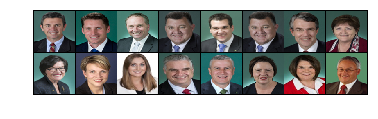

[[ 0.63      ]
 [ 0.98100001]
 [ 0.99409997]
 [ 0.98500001]
 [ 0.01      ]
 [ 0.98699999]
 [ 0.01      ]
 [ 0.01      ]]


In [15]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter) 
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated), "")
print(example_batch[2].numpy())

## Neural Net Definition

This net contains:

1. An image layer
2. A convolution layer with 16 kernels
3. A convolution layer with 16 kernels
3. A convolution layer with 8 kernels
4. A fully-connected layer with 500 neurons
5. A fully-connected layer with 500 neurons
6. A fully-connected layer with 10 neurons

The final layer feeds into the "Siamese Network" comparison (Contrastive Loss), which drives the network to provide separation between dissimilar voters which can be exploited at inference time.

In [42]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 10))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [43]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [44]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [45]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [46]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.2585787773132324

Epoch number 0
 Current loss 3.0354115962982178

Epoch number 0
 Current loss 1.844256043434143

Epoch number 0
 Current loss 1.1435261964797974

Epoch number 0
 Current loss 1.2473373413085938

Epoch number 0
 Current loss 1.2001595497131348

Epoch number 0
 Current loss 1.1917411088943481

Epoch number 0
 Current loss 1.0278457403182983

Epoch number 0
 Current loss 1.0144644975662231

Epoch number 0
 Current loss 0.9653340578079224

Epoch number 0
 Current loss 0.6029911637306213

Epoch number 0
 Current loss 0.5621811151504517

Epoch number 0
 Current loss 0.38529932498931885

Epoch number 0
 Current loss 0.3905836343765259

Epoch number 0
 Current loss 0.358678936958313

Epoch number 0
 Current loss 0.4555082619190216

Epoch number 0
 Current loss 0.2824532091617584

Epoch number 0
 Current loss 0.22588063776493073

Epoch number 0
 Current loss 0.2542918026447296

Epoch number 0
 Current loss 0.27488085627555847

Epoch number 0
 Cur

Epoch number 5
 Current loss 0.13172507286071777

Epoch number 5
 Current loss 0.12086902558803558

Epoch number 5
 Current loss 0.06533652544021606

Epoch number 5
 Current loss 0.12543660402297974

Epoch number 5
 Current loss 0.169338658452034

Epoch number 5
 Current loss 0.13084468245506287

Epoch number 5
 Current loss 0.13635918498039246

Epoch number 5
 Current loss 0.11350647360086441

Epoch number 5
 Current loss 0.16162872314453125

Epoch number 5
 Current loss 0.10310226678848267

Epoch number 5
 Current loss 0.13978175818920135

Epoch number 5
 Current loss 0.10950437933206558

Epoch number 5
 Current loss 0.0920475646853447

Epoch number 5
 Current loss 0.13863451778888702

Epoch number 5
 Current loss 0.17778591811656952

Epoch number 5
 Current loss 0.16020110249519348

Epoch number 5
 Current loss 0.1291404813528061

Epoch number 5
 Current loss 0.07631991058588028

Epoch number 5
 Current loss 0.10718812793493271

Epoch number 5
 Current loss 0.14316216111183167

Epoc

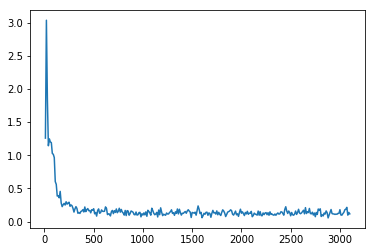

In [47]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

## Observations

* This network doesn't really need 10 epochs to train, as it looks like it has converged within the first two epochs
* This is a very silly idea with a very small labelling set, so it's not surprising that it converges rapidly
* I would be very concerned if this worked, as that would have very troublesome implications for our democracy.

## Testing

Ten politicians were held out from the training, and will be used to test. We've converted back to "friend" scores here, so higher scores imply a greater likelihood of voting the same way in parliamentary divisions. Ideally, if the model is effective, you should see "Friend Score" and "Label" being similar, and at the very least they should both be high or both be low. 

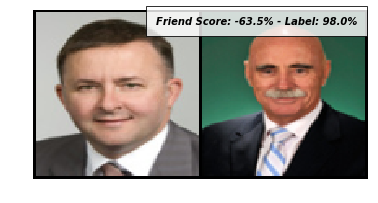

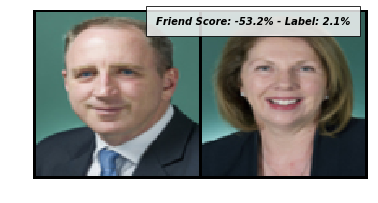

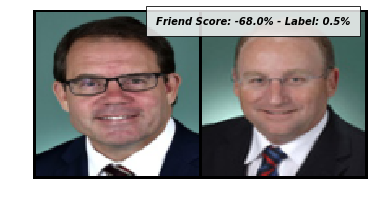

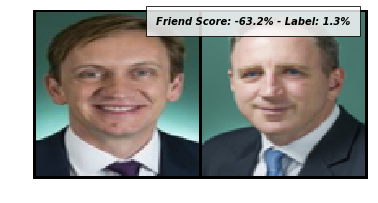

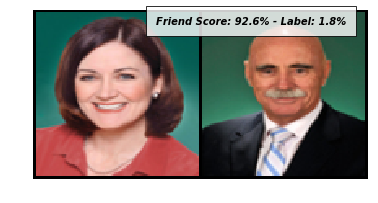

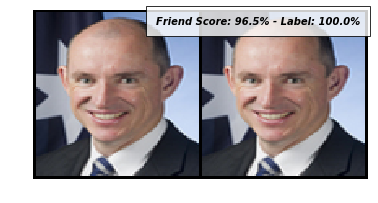

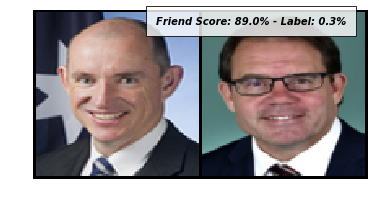

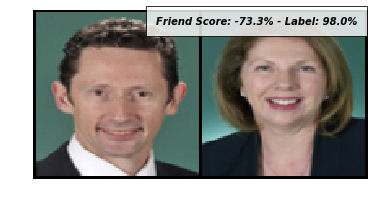

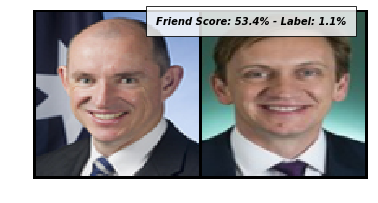

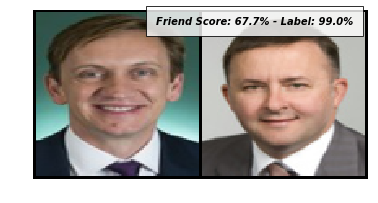

In [48]:
test_dataset = SiameseNetworkDataset(pollies = df.loc[df.testing == True],
                                     imageFolderDataset = folder_dataset,
                                     distMat = vote_dist,
                                     transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                     ,should_invert=False)
test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
next(dataiter)

for i in range(10):
    x0,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = (1 - F.pairwise_distance(output1, output2)) * 100
    friend_text = 'Friend Score: {:.1f}%'.format(euclidean_distance.cpu().data.numpy()[0][0])
    label = (1 - label2[0][0]) * 100
    label_text = 'Label: {:.1f}%'.format(label)
    imshow(torchvision.utils.make_grid(concatenated),friend_text + " - " + label_text)

If you take 50% as a cut-off (which sort of assumes a two-party system) then you have 5 correct predictions and 5 incorrect predictions. Which is the same as flipping a coin.

I have to admit I'm a little relieved that this didn't really work, as that would imply that the major parties had visibly different people elected to parliament. The failure of this model is a triumph of representative democracy, or something like that.